# Introduction
This document explains the series of steps in training the model. 
The pipeline for the deployment is present in the source code file which utilizes the steps involved in this document. 
The document also explains the uses of the model built in this exercise to the company.

Import the required libraries

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

Load the dataset and observe the shape of data frame

In [49]:
#load dataset
train_propensify = pd.read_excel(r"C:\Users\HARI CHARAN\Downloads\UPGRAD_ALL\Upgrad\train.xlsx")
train_propensify.shape

(8240, 24)

Check if there are any unnecessary columns

In [50]:
train_propensify.columns


Index(['custAge', 'profession', 'marital', 'schooling', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail',
       'responded', 'profit', 'id'],
      dtype='object')

The data is highly imbalanced, with around 88% of the customers are not responded while only 11% of them responded to the marketing campaign. Hence it is essential to address this imbalance of the target variable before building the model.

In [51]:
# Calculate value counts
value_counts = train_propensify['responded'].value_counts()

# Calculate percentages
percentages = value_counts / len(train_propensify) * 100

# Display the result
print(percentages)

responded
no     88.713592
yes    11.262136
Name: count, dtype: float64


Keeping only those columns that are required for the analysis

In [52]:
#Keeping only those columns that are required
columns_to_keep = ['custAge', 'profession', 'marital', 'schooling', 'default', 'housing',
                   'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
                   'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                   'euribor3m', 'nr.employed', 'pmonths', 'pastEmail', 'responded']

train_propensify = train_propensify[columns_to_keep]
train_propensify.shape

(8240, 22)

-------------------------------------------------------------------------------------------------------------------------------

# Treating Missing Values

Check if there are any missing values in the data

In [53]:
missing_values = train_propensify.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
custAge           2016
profession           2
marital              2
schooling         2408
default              2
housing              2
loan                 2
contact              2
month                2
day_of_week        789
campaign             2
pdays                2
previous             2
poutcome             2
emp.var.rate         2
cons.price.idx       2
cons.conf.idx        2
euribor3m            2
nr.employed          2
pmonths              2
pastEmail            2
responded            2
dtype: int64


Age, day of the week and schooling have missing values that almost account for 25% of the entire dataset.
Age can have significant impact on the response to the marketing campaign for insurance products as individuals belonging to
different categories of age may have different needs (Young to old). 
Day of the week can influence the decision too as individuals tend to be free in weekends and busy in week days.
Further, schooling represents the indiviudual's education level which can have significant impact on decision to get insured.
Thus, dropping these variables is not the ideal thing to do.
Hence, the missing values are to be imputed and this section discusses the imputation techniques used.

1. Imputing missing schooling values:
Education can have impact on the employment type of the individual. Hence, this study checks education levels and the associated 
profession of the individual to cross-check the education-employment match argument. The following table acts as an evidence for the above argument.
Considering the above argument the missing education values are imputed based on the indivisual's profession

In [54]:
cross_tab = pd.crosstab(train_propensify['schooling'], train_propensify['profession'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: yellow' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

profession,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
schooling,,,,,,,,,,,,
basic.4y,2.047782,55.802048,4.436860,10.409556,2.389078,14.675768,1.706485,3.242321,0.341297,0.853242,2.730375,1.365188
basic.6y,8.626198,61.022364,1.597444,4.792332,4.472843,4.153355,0.000000,10.543131,0.638978,3.194888,0.958466,0.000000
basic.9y,7.184241,61.413673,3.012746,2.085747,2.201622,1.738123,4.287370,6.836616,0.926999,6.604867,3.128621,0.579374
high.school,36.268657,8.805970,2.686567,1.492537,3.358209,2.313433,1.567164,27.985075,3.358209,9.179104,2.686567,0.298507
illiterate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
professional.course,7.046070,9.756098,3.387534,1.761518,1.897019,4.065041,2.303523,4.065041,0.948509,62.466125,2.032520,0.271003
university.degree,47.198151,0.693241,5.661467,1.270942,16.811092,2.195263,5.430387,1.328712,1.213172,16.233391,1.559792,0.404391
unknown,16.538462,25.000000,3.461538,3.846154,6.923077,6.153846,1.923077,5.384615,9.230769,10.769231,0.384615,10.384615


In [55]:
#Feature engineering for schooling
schooling_category = {
    'basic.4y' : 'basic',
    'basic.6y' : 'basic',
    'basic.9y' : 'basic',
    'high.school': 'high.school',
    'illiterate':'illiterate',
    'professional.course': 'professional.course',
    'university.degree':'university.degree',
    'unknown':'unknown',
}

train_propensify['schooling'] = train_propensify['schooling'].replace(schooling_category)

In [56]:
cross_tab = pd.crosstab(train_propensify['schooling'], train_propensify['profession'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: yellow' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

profession,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
schooling,,,,,,,,,,,,
basic,5.732123,59.477866,3.234960,5.334847,2.667423,6.469921,2.667423,6.299659,0.681044,4.086266,2.610670,0.737798
high.school,36.268657,8.805970,2.686567,1.492537,3.358209,2.313433,1.567164,27.985075,3.358209,9.179104,2.686567,0.298507
illiterate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
professional.course,7.046070,9.756098,3.387534,1.761518,1.897019,4.065041,2.303523,4.065041,0.948509,62.466125,2.032520,0.271003
university.degree,47.198151,0.693241,5.661467,1.270942,16.811092,2.195263,5.430387,1.328712,1.213172,16.233391,1.559792,0.404391
unknown,16.538462,25.000000,3.461538,3.846154,6.923077,6.153846,1.923077,5.384615,9.230769,10.769231,0.384615,10.384615


In [57]:
# Imputation of missing values in education based on profession

imputation_mapping = {
    'blue-collar' : 'basic',
    'self-employed': 'illiterate',
    'technician'   : 'professional.course',
    'admin.'        : 'university.degree',
    'services'      : 'high.school',
    'management'    : 'university.degree',
    'retired'       : 'unknown',
    'entrepreneur'  : 'university.degree'
}

In [58]:
train_propensify['schooling'] = train_propensify['schooling'].combine_first(train_propensify['profession'].map(imputation_mapping))

2. Treating missing age values
The age of an individual can have an impact on the working status of the individual. A student's age can be much lower as compared to a retired individual while a working individual's age can be expected to lie in between these two categories.
Hence the age values are imputed based on the employment status (created from profession column) of the individual.
The plot of comparision for customer age across retired, student and working individuals supports the above argument.

In [59]:
#Profession & treating missing values of age
train_propensify['employment_status'] = train_propensify['profession'].apply(lambda x: 'retired' if x == 'retired' else ('student' if x == 'student' else 'working'))

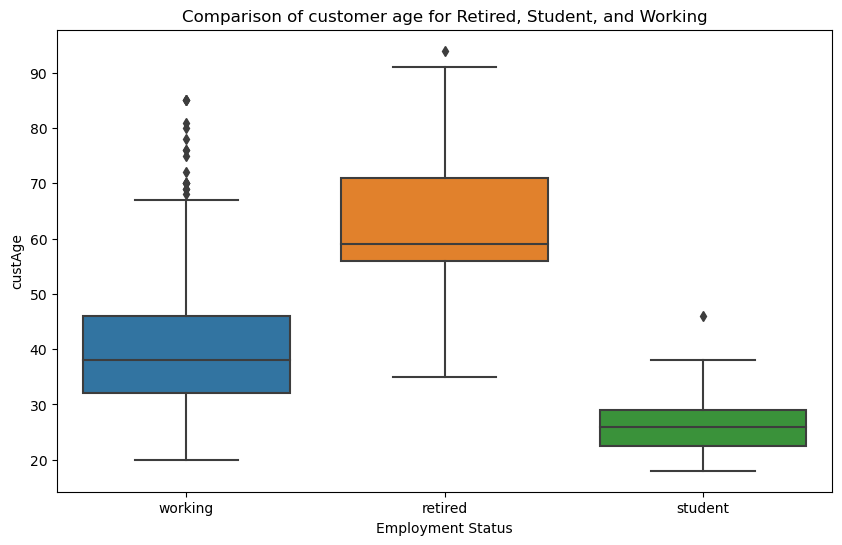

In [60]:
#Age comparision w.r.t profession
plt.figure(figsize=(10, 6))
sns.boxplot(x='employment_status', y='custAge', data=train_propensify)
plt.title('Comparison of customer age for Retired, Student, and Working')
plt.xlabel('Employment Status')
plt.ylabel('custAge')
plt.show()

Imputing mean values for missing age values of retired and student categories and imputing with median for working category 
(As there are outliers in this category)

In [61]:
# Imputing age values
# Calculate mean and median values for each profession
mean_age_retired = train_propensify.loc[train_propensify['employment_status'] == 'retired', 'custAge'].mean()
mean_age_student = train_propensify.loc[train_propensify['employment_status'] == 'student', 'custAge'].mean()
median_age_working = train_propensify.loc[train_propensify['employment_status'] == 'working', 'custAge'].median()

# Fill missing values based on profession-specific mean or median
train_propensify['custAge'] = np.where((train_propensify['employment_status'] == 'retired') & train_propensify['custAge'].isna(), mean_age_retired, train_propensify['custAge'])
train_propensify['custAge'] = np.where((train_propensify['employment_status'] == 'student') & train_propensify['custAge'].isna(), mean_age_student, train_propensify['custAge'])
train_propensify['custAge'] = np.where((train_propensify['employment_status'] == 'working') & train_propensify['custAge'].isna(), median_age_working, train_propensify['custAge'])


3. Imputing day of week variable:
    The distribution of day of week plot can show that marketing campaign is equally distributed among all the days. Hence the
    missing values of day of the week are imputed based on random function.

In [62]:
day_values = train_propensify['day_of_week'].value_counts()
print(day_values)

day_of_week
mon    1598
thu    1533
tue    1478
wed    1473
fri    1369
Name: count, dtype: int64


In [63]:
cross_tab = pd.crosstab(train_propensify['day_of_week'], train_propensify['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: yellow' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
day_of_week,,
fri,88.093499,11.906501
mon,90.488110,9.511890
thu,87.932159,12.067841
tue,88.159675,11.840325
wed,89.341480,10.658520


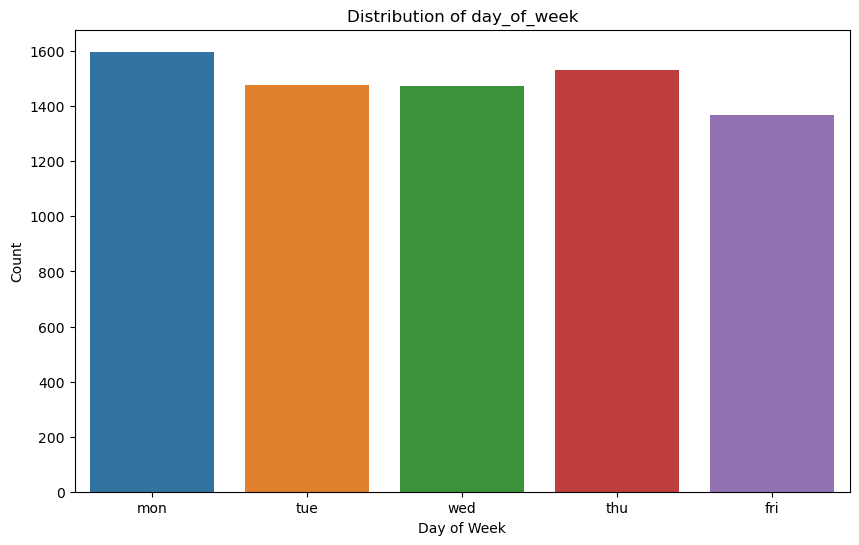

In [64]:
#day of week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=train_propensify, order=['mon', 'tue', 'wed', 'thu', 'fri'])
plt.title('Distribution of day_of_week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

In [65]:
def impute_random_day(day):
    if pd.isna(day):
        return np.random.choice(['mon', 'tue', 'wed', 'thu', 'fri'])
    else:
        return day

# Apply the imputation function to the 'day_of_week' column
train_propensify['day_of_week'] = train_propensify['day_of_week'].apply(impute_random_day)

In [66]:
missing_values = train_propensify.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
custAge                0
profession             2
marital                2
schooling            189
default                2
housing                2
loan                   2
contact                2
month                  2
day_of_week            0
campaign               2
pdays                  2
previous               2
poutcome               2
emp.var.rate           2
cons.price.idx         2
cons.conf.idx          2
euribor3m              2
nr.employed            2
pmonths                2
pastEmail              2
responded              2
employment_status      0
dtype: int64


Dropping the remaining missing values (which are minimal as compared to the data frame size)

In [67]:
#Now, dropping remaining missing values
train_propensify = train_propensify.dropna()

In [68]:
#cross check
missing_values = train_propensify.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
custAge              0
profession           0
marital              0
schooling            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
pmonths              0
pastEmail            0
responded            0
employment_status    0
dtype: int64


In [69]:
train_propensify.shape

(8051, 23)

-------------------------------------------------------------------------------------------------------------------------------

# Feature Engineering 

Feature engineering of categorical variables:

1. Profession:
The profession can be label encoded whether an individual is dependent or working. Dependents insurance is in general 
taken care by the head of the family or by the state. Hence the label encoding is done accordingly.

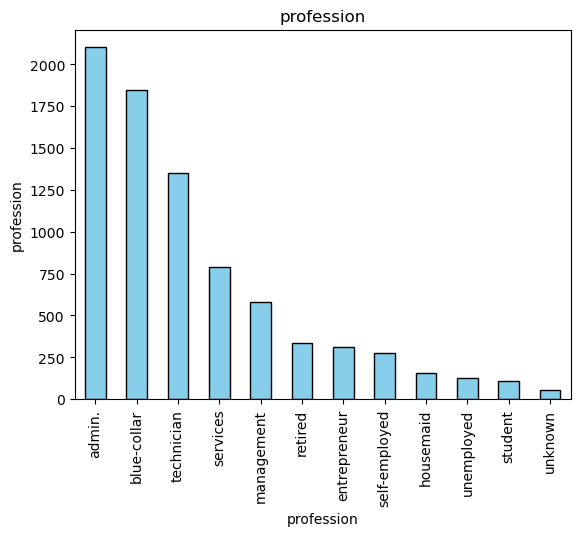

In [70]:

#1. Profession
train_propensify['profession'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('profession')
plt.xlabel('profession')
plt.ylabel('profession')
plt.show()

In [71]:
cross_tab = pd.crosstab(train_propensify['profession'], train_propensify['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: yellow' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
profession,,
admin.,87.155090,12.844910
blue-collar,91.932864,8.067136
entrepreneur,90.764331,9.235669
housemaid,91.194969,8.805031
management,88.850772,11.149228
retired,76.557864,23.442136
self-employed,87.813620,12.186380
services,92.550505,7.449495
student,63.302752,36.697248


In [72]:
#Label encoding
train_propensify['profession'] = train_propensify['profession'].map({'student': 'Dependents', 'retired': 'Dependents', 'unemployed': 'Unemployed&Unknown', 'unknown': 'Unemployed&Unknown', 
                                                    'admin.': 'Working','blue-collar': 'Working','entrepreneur': 'Working','housemaid': 'Working',
                                                   'management': 'Working','self-employed': 'Working','services': 'Working','technician': 'Working'})

# Display the updated DataFrame
train_propensify['profession'].value_counts()

profession
Working               7427
Dependents             446
Unemployed&Unknown     178
Name: count, dtype: int64

2. Marital:
Considering single and divorcee as a single caregory and keeping married and unknown as different categories

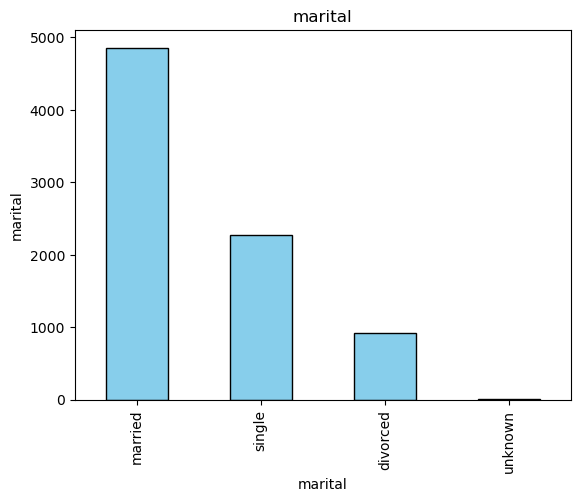

In [73]:
#2. Marital
train_propensify['marital'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('marital')
plt.xlabel('marital')
plt.ylabel('marital')
plt.show()

In [74]:
cross_tab = pd.crosstab(train_propensify['marital'], train_propensify['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: yellow' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
marital,,
divorced,89.934354,10.065646
married,89.728283,10.271717
single,86.475771,13.524229
unknown,77.777778,22.222222


In [75]:
#Label encoding
train_propensify['marital'] = train_propensify['marital'].map({'single': 'Single&Divorced', 'divorced': 'Single&Divorced', 
                                                                     'married': 'married', 'unknown': 'Unknown', })

# Display the updated DataFrame
train_propensify['marital'].value_counts()

marital
married            4858
Single&Divorced    3184
Unknown               9
Name: count, dtype: int64

3. Schooling:
An indiviudual's education can explain whether an indiidual is illiterate, or basic-educated or educated. Label encoding accordingly.

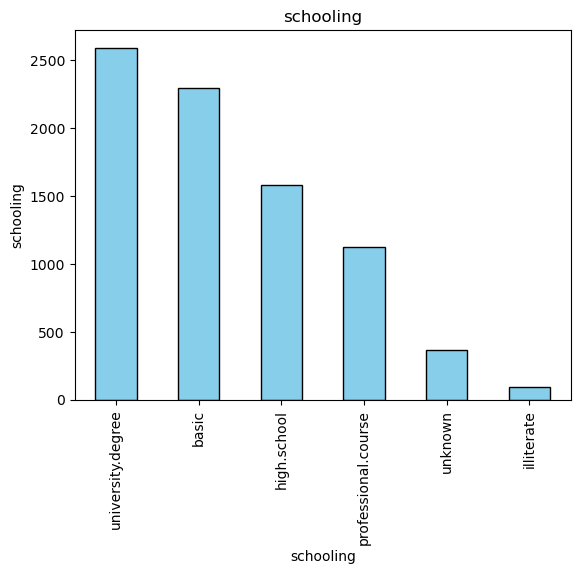

In [76]:
#3. Schooling
train_propensify['schooling'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('schooling')
plt.xlabel('schooling')
plt.ylabel('schooling')
plt.show()

In [77]:
cross_tab = pd.crosstab(train_propensify['schooling'], train_propensify['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: yellow' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
schooling,,
basic,91.325196,8.674804
high.school,89.550348,10.449652
illiterate,87.368421,12.631579
professional.course,89.412811,10.587189
university.degree,87.032034,12.967966
unknown,81.250000,18.750000


In [78]:
#Label encoding
train_propensify['schooling'] = train_propensify['schooling'].map({'basic': 'Uneducated&BasicEducation', 'high.school': 'Uneducated&BasicEducation', 
                                                                     'illiterate': 'Uneducated&BasicEducation', 
                                                                   'unknown': 'Unknown',
                                                                  'professional.course': 'Educated',
                                                                  'university.degree': 'Educated',
                                                                  })

# Display the updated DataFrame
train_propensify['schooling'].value_counts()

schooling
Uneducated&BasicEducation    3968
Educated                     3715
Unknown                       368
Name: count, dtype: int64

4. Default:
Yes and Unknown are grouped together and No is kept as a seperate category

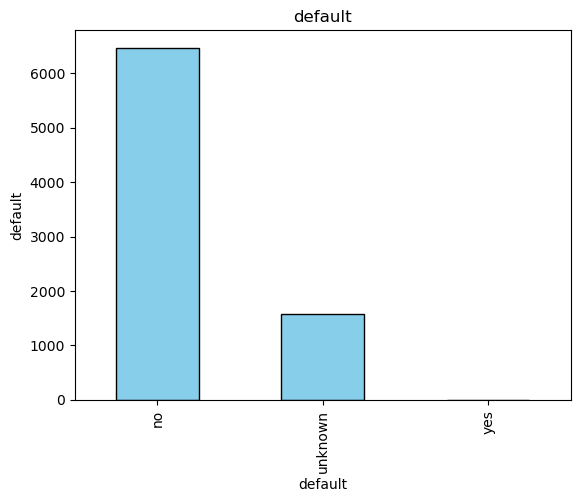

In [79]:
#Default
train_propensify['default'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('default')
plt.xlabel('default')
plt.ylabel('default')
plt.show()

In [80]:
#Label encoding
train_propensify['default'] = train_propensify['default'].map({'no': 'No', 'unknown': 'Yes&Unknown','yes':'Yes&Unknown' })

# Display the updated DataFrame
train_propensify['default'].value_counts()

default
No             6470
Yes&Unknown    1581
Name: count, dtype: int64

5. Housing is kept unchanged

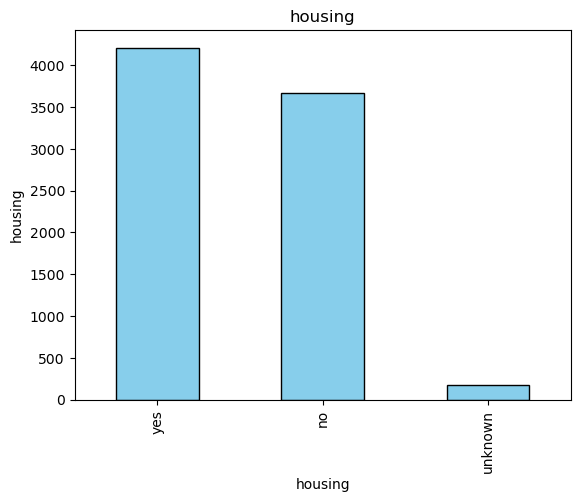

In [81]:
#housing
train_propensify['housing'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('housing')
plt.xlabel('housing')
plt.ylabel('housing')
plt.show()

6. Loan is kept unchanged

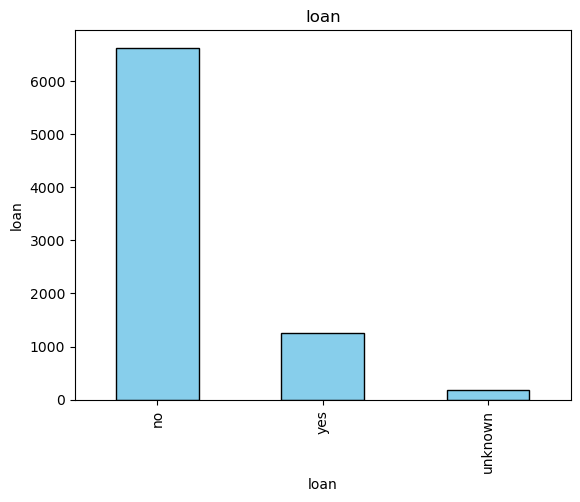

In [82]:
#loan
train_propensify['loan'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('loan')
plt.xlabel('loan')
plt.ylabel('loan')
plt.show()

7. Contact is kept unchanged

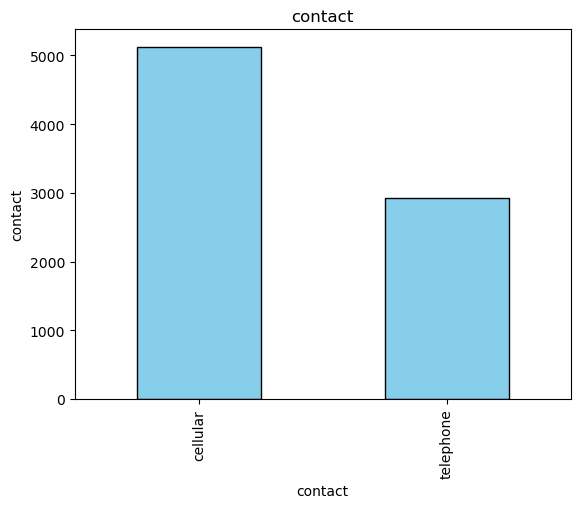

In [83]:
#contact
train_propensify['contact'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('contact')
plt.xlabel('contact')
plt.ylabel('contact')
plt.show()

8. Month:
Sales team tend to have sales pressure in quarter end hence there is a possibility to focus on marketing campaign on these months. Hence label encoding accordingly

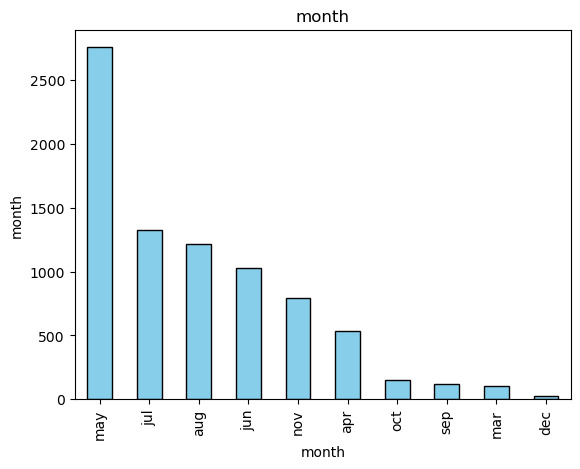

In [84]:
#month
train_propensify['month'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('month')
plt.xlabel('month')
plt.ylabel('month')
plt.show()

In [85]:
cross_tab = pd.crosstab(train_propensify['month'], train_propensify['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: yellow' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
month,,
apr,77.094972,22.905028
aug,91.043550,8.956450
dec,44.827586,55.172414
jul,91.189759,8.810241
jun,90.155945,9.844055
mar,51.456311,48.543689
may,92.849365,7.150635
nov,91.898734,8.101266
oct,57.046980,42.953020


In [86]:
# Create a copy of the DataFrame to avoid modifying the original data
train_propensify_copy_c = train_propensify.copy()

# Define a mapping for specific months
quarter_mapping = {'dec': 'QuarterEnd', 'sep': 'QuarterEnd', 'jun': 'QuarterEnd', 'mar': 'QuarterEnd'}

# Replace specified months with 'QuarterEnd' in the copied DataFrame
train_propensify_copy_c['month_mapped'] = train_propensify_copy_c['month'].replace(quarter_mapping)

# Replace other months with 'others' in the copied DataFrame
train_propensify_copy_c['month_mapped'].replace(to_replace=train_propensify_copy_c['month_mapped'][~train_propensify_copy_c['month_mapped'].isin(['QuarterEnd'])].unique(), value='others', inplace=True)

# Display the value counts of the new variable
print(train_propensify_copy_c['month_mapped'].value_counts())

train_propensify['month'] = train_propensify_copy_c['month_mapped']
train_propensify['month'].value_counts()

month_mapped
others        6776
QuarterEnd    1275
Name: count, dtype: int64


month
others        6776
QuarterEnd    1275
Name: count, dtype: int64

9. Day of week:
Considering the customer's leisure time availabilty to label encode day of week.

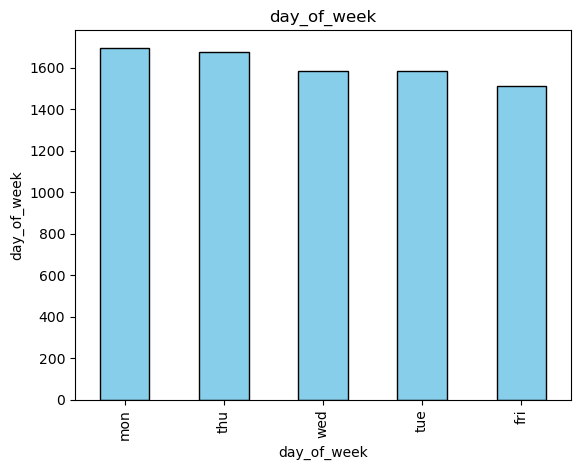

In [87]:
#Day_of_week
train_propensify['day_of_week'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('day_of_week')
plt.xlabel('day_of_week')
plt.ylabel('day_of_week')
plt.show()

In [88]:
#Label encoding
train_propensify['day_of_week'] = train_propensify['day_of_week'].map({'mon': 'WeekBeginning', 'tue': 'WeekBeginning','wed':'WeekBeginning',
                                                                      'thu':'WeekEnding','fri':'WeekEnding'})

# Display the updated DataFrame
train_propensify['day_of_week'].value_counts()

day_of_week
WeekBeginning    4862
WeekEnding       3189
Name: count, dtype: int64

10. Feature engineering pdays and pmonths by addressing 999

In [89]:
# Feature engineering of other variables

#pdays
conditions = [
    (train_propensify['pdays'] == 999),
    (train_propensify['pdays'] < 5),
    ((train_propensify['pdays'] >= 5) & (train_propensify['pdays'] <= 10)),
    (train_propensify['pdays'] > 10)
]

choices = ['first visit', 'less than 5 days', '5 to 10 days', 'greater than 10 days']

# Create the 'pduration' column based on conditions
train_propensify['pduration'] = np.select(conditions, choices, default='unknown')

#pmonths
conditions = [
    (train_propensify['pmonths'] == 999),
    (train_propensify['pmonths'] <= 0.2),
    (train_propensify['pmonths'] > 0.2)
]

choices = ['first visit', 'less than 2 months',  'greater than 2 months']

# Create the 'pduration' column based on conditions
train_propensify['pduration_m'] = np.select(conditions, choices, default='unknown')


In [90]:
train_propensify.dtypes

custAge              float64
profession            object
marital               object
schooling             object
default               object
housing               object
loan                  object
contact               object
month                 object
day_of_week           object
campaign             float64
pdays                float64
previous             float64
poutcome              object
emp.var.rate         float64
cons.price.idx       float64
cons.conf.idx        float64
euribor3m            float64
nr.employed          float64
pmonths              float64
pastEmail            float64
responded             object
employment_status     object
pduration             object
pduration_m           object
dtype: object

----------------------------------------------------------------------------------------------------------------------------

# One hot encoding categoric features and normalizing continuous features

In [91]:
# One hot encoding and normalization for appropriate variables 
# Drop target and unnecessary columns
X = train_propensify.drop(['responded', 'pdays','pmonths','employment_status'], axis=1)
y = train_propensify['responded']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=['loan', 'marital', 'schooling', 'default', 'housing', 'day_of_week',
                                       'poutcome', 'pduration','pduration_m','profession','month','contact' ],drop_first=True)

# Identify continuous columns for normalization
continuous_columns = ['custAge','campaign','previous', 'emp.var.rate','cons.price.idx','cons.conf.idx',
                      'euribor3m','nr.employed','pastEmail'
                       ]


In [92]:
# Extract the continuous columns from X_encoded
X_continuous = X_encoded[continuous_columns]

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the continuous data
X_continuous_normalized = scaler.fit_transform(X_continuous)

# Replace the original continuous columns in X_encoded with the normalized ones
X_encoded[continuous_columns] = X_continuous_normalized



In [93]:
X_encoded.columns

Index(['custAge', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'pastEmail',
       'loan_unknown', 'loan_yes', 'marital_Unknown', 'marital_married',
       'schooling_Uneducated&BasicEducation', 'schooling_Unknown',
       'default_Yes&Unknown', 'housing_unknown', 'housing_yes',
       'day_of_week_WeekEnding', 'poutcome_nonexistent', 'poutcome_success',
       'pduration_first visit', 'pduration_greater than 10 days',
       'pduration_less than 5 days', 'pduration_m_greater than 2 months',
       'pduration_m_less than 2 months', 'profession_Unemployed&Unknown',
       'profession_Working', 'month_others', 'contact_telephone'],
      dtype='object')

-------------------------------------------------------------------------------------------------------------------------------

# Choice of sampling:
Since the data is imbalanced there is a need to resample. The available options are undersampling, oversampling and mixed sampling. Since the data is highly imbalanced, oversampling could lead to create too much of synthetic data for the minority class and undersampling could lead to the loss of information. Hence mixed sampling is done using the SMOTE-NN method. It utilizes k-nearest neighbors to generate synthetic instances.


-------------------------------------------------------------------------------------------------------------------------------

# Choice of metrics and model:
Since the data is highly imbalanced machine learning algorithms tend to predict the majority class (Here "No" i.e., not responded is the majority class) and thus, models tend to have high overall accurancy.

However, since it is a propensity model, choosing not to market to an individual who could be potential customer will be costly 
to the company. Hence it is essential to improve the recall of minority class (Here "Yes" i.e., responded is minority class) is essential too.

If the model just focuses on accuracy (A RFC can achieve 89% accuracy even with out addressing the imbalnce in data, however, the recall of minority data will be nearly 20%), the company tend to not choose to do marketing to the potential customers, which could be a loss to the company.

On the other hand accuracy is important too, else marketing costs will drastically increase as the marketing will be done to those individuals who do not buy the product. 

Thus, there is a need for balance. The metrics given in the project is an accurancy of above 85%. However, this report focuses on maximizing the accuracy and recall of minority class. That is the model tries the maximize the recall while trying to keep the accuracy above 85%.

To improve accuracy and recall, ensembling technique is used and the algorithms considered are Random Forest Classifier and Support Vector Machines.

----------------------------------------------------------------------------------------------------------------------------

# Model

In [95]:
#Ensembling without gridsearchcv, using rbf for SVC

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


y_train = np.array(y_train)
y_test = np.array(y_test)

# Apply SMOTEENN to the training data
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a Linear Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)

# Ensemble the classifiers using a VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('svm', svm_classifier)
], voting='hard')  # 'hard' for probability voting

# Fit the ensemble model on the resampled training data
ensemble_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = ensemble_classifier.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Display number of true positives, true negatives, false positives, and false negatives
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

          no       0.95      0.89      0.92      1431
         yes       0.40      0.60      0.48       180

    accuracy                           0.86      1611
   macro avg       0.67      0.74      0.70      1611
weighted avg       0.89      0.86      0.87      1611

Confusion Matrix:
[[1271  160]
 [  72  108]]
True Positives: 108
True Negatives: 1271
False Positives: 160
False Negatives: 72


# Utility of the Model
It can be observed from the above results that the recall of minority class is maximized while keeping the accuracy above 85% as required by the project. Hence the model keeps the fine balance between accuracy and recall of minority class so that the company does not loose out too much on marketing cost and at the same time it tries to make sure that the most of the potential customers are treated with the marketing campaign so that the company does not loose out the potential customers.

-----------------------------------------------------------------------------------------------------------------------